<a href="https://colab.research.google.com/github/akanksha0911/ScratchPython/blob/main/255_Catchup_assign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 apriori algorithm

Apriori assumes that

All subsets of a frequent itemset must be frequent(Apriori propertry).
If an itemset is infrequent, all its supersets will be infrequent.

In [397]:
from __future__ import division, print_function
import numpy as np
import itertools


class Rule():
    def __init__(self, antecedent, concequent, confidence, support):
        self.antecedent = antecedent
        self.concequent = concequent
        self.confidence = confidence
        self.support = support


class Apriori():

    def __init__(self, min_sup=0.3, min_conf=0.81):

        self.min_sup = min_sup
        self.min_conf = min_conf
        self.freq_itemsets = None       # List of freqeuent itemsets
        self.transactions = None        # List of transactions

    def _calculate_support(self, itemset):
        count = 0
        for transaction in self.transactions:
            if self._transaction_contains_items(transaction, itemset):
                count += 1
        support = count / len(self.transactions)
        return support


    def _get_frequent_itemsets(self, candidates):
        """ Prunes the candidates that are not frequent => returns list with 
        only frequent itemsets """
        frequent = []
        # Find frequent items
        for itemset in candidates:
            support = self._calculate_support(itemset)
            if support >= self.min_sup:
                frequent.append(itemset)
        return frequent


    def _has_infrequent_itemsets(self, candidate):
        """ True or false depending on the candidate has any
        subset with size k - 1 that is not in the frequent itemset """
        k = len(candidate)
        # Find all combinations of size k-1 in candidate
        # E.g [1,2,3] => [[1,2],[1,3],[2,3]]
        subsets = list(itertools.combinations(candidate, k - 1))
        for t in subsets:
            # t - is tuple. If size == 1 get the element
            subset = list(t) if len(t) > 1 else t[0]
            if not subset in self.freq_itemsets[-1]:
                return True
        return False


    def _generate_candidates(self, freq_itemset):
        """ Joins the elements in the frequent itemset and prunes
        resulting sets if they contain subsets that have been determined
        to be infrequent. """
        candidates = []
        for itemset1 in freq_itemset:
            for itemset2 in freq_itemset:
                # Valid if every element but the last are the same
                # and the last element in itemset1 is smaller than the last
                # in itemset2
                valid = False
                single_item = isinstance(itemset1, int)
                if single_item and itemset1 < itemset2:
                    valid = True
                elif not single_item and np.array_equal(itemset1[:-1], itemset2[:-1]) and itemset1[-1] < itemset2[-1]:
                    valid = True

                if valid:
                    # JOIN: Add the last element in itemset2 to itemset1 to
                    # create a new candidate
                    if single_item:
                        candidate = [itemset1, itemset2]
                    else:
                        candidate = itemset1 + [itemset2[-1]]
                    # PRUNE: Check if any subset of candidate have been determined
                    # to be infrequent
                    infrequent = self._has_infrequent_itemsets(candidate)
                    if not infrequent:
                        candidates.append(candidate)
        return candidates


    def _transaction_contains_items(self, transaction, items):
        """ True or false depending on each item in the itemset is
        in the transaction """
        # If items is in fact only one item
        if isinstance(items, int):
            return items in transaction
        # Iterate through list of items and make sure that
        # all items are in the transaction
        for item in items:
            if not item in transaction:
                return False
        return True

    def find_frequent_itemsets(self, transactions):
        """ Returns the set of frequent itemsets in the list of transactions """
        self.transactions = transactions
        # Get all unique items in the transactions
        unique_items = set(item for transaction in self.transactions for item in transaction)
        # Get the frequent items
        self.freq_itemsets = [self._get_frequent_itemsets(unique_items)]
        while(True):
            # Generate new candidates from last added frequent itemsets
            candidates = self._generate_candidates(self.freq_itemsets[-1])
            # Get the frequent itemsets among those candidates
            frequent_itemsets = self._get_frequent_itemsets(candidates)

            # If there are no frequent itemsets we're done
            if not frequent_itemsets:
                break

            # Add them to the total list of frequent itemsets and start over
            self.freq_itemsets.append(frequent_itemsets)

        # Flatten the array and return every frequent itemset
        frequent_itemsets = [
            itemset for sublist in self.freq_itemsets for itemset in sublist]
        return frequent_itemsets


    def _rules_from_itemset(self, initial_itemset, itemset):
        """ Recursive function which returns the rules where confidence >= min_confidence
        Starts with large itemset and recursively explores rules for subsets """
        rules = []
        k = len(itemset)
        # Get all combinations of sub-itemsets of size k - 1 from itemset
        # E.g [1,2,3] => [[1,2],[1,3],[2,3]]
        subsets = list(itertools.combinations(itemset, k - 1))
        support = self._calculate_support(initial_itemset)
        for antecedent in subsets:
            # itertools.combinations returns tuples => convert to list
            antecedent = list(antecedent)
            antecedent_support = self._calculate_support(antecedent)
            # Calculate the confidence as sup(A and B) / sup(B), if antecedent
            # is B in an itemset of A and B
            confidence = float("{0:.2f}".format(support / antecedent_support))
            if confidence >= self.min_conf:
                # The concequent is the initial_itemset except for antecedent
                concequent = [itemset for itemset in initial_itemset if not itemset in antecedent]
                # If single item => get item
                if len(antecedent) == 1:
                    antecedent = antecedent[0]
                if len(concequent) == 1:
                    concequent = concequent[0]
                # Create new rule
                rule = Rule(
                        antecedent=antecedent,
                        concequent=concequent,
                        confidence=confidence,
                        support=support)
                rules.append(rule)
                    
                # If there are subsets that could result in rules
                # recursively add rules from subsets
                if k - 1 > 1:
                    rules += self._rules_from_itemset(initial_itemset, antecedent)
        return rules

    def generate_rules(self, transactions):
        self.transactions = transactions
        frequent_itemsets = self.find_frequent_itemsets(transactions)
        # Only consider itemsets of size >= 2 items
        frequent_itemsets = [itemset for itemset in frequent_itemsets if not isinstance(
                itemset, int)]
        rules = []
        for itemset in frequent_itemsets:
            rules += self._rules_from_itemset(itemset, itemset)
        # Remove empty values
        return rules

Implement above class

In [398]:
transactions = np.array([[1, 2, 3, 4], [1, 2, 4], [1, 2], [2, 3, 4], [2, 3], [3, 4], [2, 4]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [399]:
 min_sup = 0.25
 min_conf = 0.8
 print ("Minimum Support: %.2f" % (min_sup))
 print ("Minimum Confidence: %s" % (min_conf))
 print ("Transactions:")
 for transaction in transactions:
        print ("\t%s" % transaction)

 apriori = Apriori(min_sup=min_sup, min_conf=min_conf)

Minimum Support: 0.25
Minimum Confidence: 0.8
Transactions:
	[1, 2, 3, 4]
	[1, 2, 4]
	[1, 2]
	[2, 3, 4]
	[2, 3]
	[3, 4]
	[2, 4]


In [400]:

rules = apriori.generate_rules(transactions)

In [401]:
print ("Rules:")
for rule in rules:
        print ("\t%s -> %s (support: %.2f, confidence: %s)" % (rule.antecedent, rule.concequent, rule.support, rule.confidence,))

Rules:
	1 -> 2 (support: 0.43, confidence: 1.0)
	4 -> 2 (support: 0.57, confidence: 0.8)
	[1, 4] -> 2 (support: 0.29, confidence: 1.0)


1. K-means 

The kMeans algorithm finds those k points (called centroids) that minimize the sum of squared errors. This process is done iteratively until the total error is not reduced anymore. At that time we will have reached a minimum and our observations will be classified into different groups or clusters.


Choose value for K
Randomly select K featuresets to start as your centroids
Calculate distance of all other featuresets to centroids
Classify other featuresets as same as closest centroid
Take mean of each class (mean of all featuresets by class), making that mean the new centroid

In [402]:
import numpy as np
from scipy.spatial.distance import cdist 
 
#Function to implement steps given in previous section
def kmeans(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,'euclidean') #Step 2
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points 

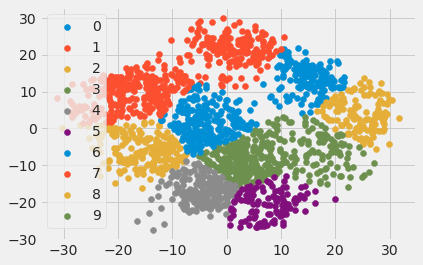

In [403]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
 
#Defining our function 
def kmeans(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distances = cdist(x, centroids ,'euclidean') #Step 2
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points 
 
 
#Load Data
data = load_digits().data
pca = PCA(2)
  
#Transform the data
df = pca.fit_transform(data)
 
#Applying our function
label = kmeans(df,10,1000)
 
#Visualize the results
 
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)

plt.legend()
plt.show()

In [404]:
centroids

array([[ -8.47453799, -10.14333222,   4.58002297,  -9.73944925,
         -0.06383295],
       [ -5.99688531,  -5.02463211,  -6.28061932,  -7.09702487,
          5.44919288]])

2- Decision Tree and Random Forest

In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")



In [406]:


df = pd.read_csv("/content/drive/MyDrive/Kaggle_data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()



,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


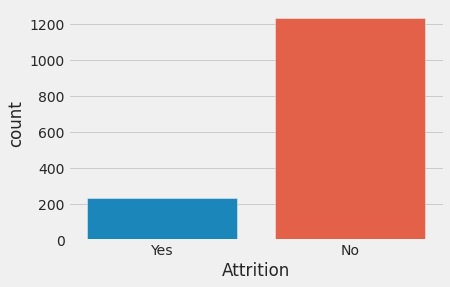

In [407]:


sns.countplot(x='Attrition', data=df)



In [408]:
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

categorical_col = []
for column in df.columns:
    if df[column].dtype == object and len(df[column].unique()) <= 50:
        categorical_col.append(column)
        
df['Attrition'] = df.Attrition.astype("category").cat.codes

In [409]:


categorical_col.remove('Attrition')



In [410]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for column in categorical_col:
    df[column] = label.fit_transform(df[column])


In [411]:
from sklearn.model_selection import train_test_split

X = df.drop('Attrition', axis=1)
y = df.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [425]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


In [413]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)


Train Result:
Accuracy Score: 87.07%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.868098    0.921569  0.870748     0.894833      0.877244
recall       0.995311    0.267045  0.870748     0.631178      0.870748
f1-score     0.927362    0.414097  0.870748     0.670730      0.839573
support    853.000000  176.000000  0.870748  1029.000000   1029.000000
_______________________________________________
Confusion Matrix: 
 [[849   4]
 [129  47]]

Test Result:
Accuracy Score: 85.94%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.866359   0.428571   0.85941    0.647465      0.805804
recall       0.989474   0.049180   0.85941    0.519327      0.859410
f1-score     0.923833   0.088235   0.85941    0.506034      0.808251
support    380.000000  61.000000   0.85941  441.000000    441.

In [414]:
importances = pd.DataFrame({"feature": X_train.columns, "importance": tree_clf.feature_importances_})
importances.sort_values("importance", ascending=False)[:10]



,feature,importance
18,OverTime,0.264745
15,MonthlyIncome,0.186576
23,TotalWorkingYears,0.120833
14,MaritalStatus,0.086246
26,YearsAtCompany,0.068939
22,StockOptionLevel,0.049396
4,DistanceFromHome,0.049342
16,MonthlyRate,0.040025
13,JobSatisfaction,0.037491
28,YearsSinceLastPromotion,0.035706


In [415]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 86.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.873832   0.538462  0.863946    0.706147      0.827443
recall       0.984211   0.114754  0.863946    0.549482      0.863946
f1-score     0.925743   0.189189  0.863946    0.557466      0.823861
support    380.000000  61.000000  0.863946  441.000000    441.000000
_______________________________________________
Conf

3- adaboost

In [416]:
import numpy as np

from sklearn.tree import DecisionTreeClassifier


def I(flag):
    return 1 if flag else 0

def sign(x):
    return abs(x)/x if x!=0 else 1       

class AdaBoost:
    
    def __init__(self,n_estimators=50):
        self.n_estimators = n_estimators
        self.models = [None]*n_estimators
        
    def fit(self,X,y):
        
        X = np.float64(X)
        N = len(y)
        w = np.array([1/N for i in range(N)])
        
        for m in range(self.n_estimators):
            
            Gm = DecisionTreeClassifier(max_depth=1)\
                        .fit(X,y,sample_weight=w).predict
                        
            errM = sum([w[i]*I(y[i]!=Gm(X[i].reshape(1,-1))) \
                        for i in range(N)])/sum(w)
            
            AlphaM = np.log((1-errM)/errM)
            
            w = [w[i]*np.exp(AlphaM*I(y[i]!=Gm(X[i].reshape(1,-1))))\
                     for i in range(N)] 
            
            
            self.models[m] = (AlphaM,Gm)

    def predict(self,X):
        
        y = 0
        for m in range(self.n_estimators):
            AlphaM,Gm = self.models[m]
            y += AlphaM*Gm(X)
        signA = np.vectorize(sign)
        y = np.where(signA(y)==-1,-1,1)
        return y

In [417]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix as CM

x,y = make_classification(n_samples=217)
'''
As for our implementaion of AdaBoost 
y needs to be in {-1,1}
'''
y = np.where(y==0,-1,1)

clf = AdaBoost(n_estimators=5)
clf.fit(x,y)
y_pred = clf.predict(x)


print("Performance:",100*sum(y_pred==y)/len(y))
print("""Confusion Matrix:""", CM(y,y_pred))

Performance: 92.16589861751152
Confusion Matrix: [[ 99  10]
 [  7 101]]


we may compare with the sklearn implementation

In [418]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=5,algorithm="SAMME")
clf.fit(x,y)
y_pred2 = clf.predict(x)

print("Performance:",sum(y_pred==y)/len(y))
print("Confusion Matrix:\n",CM(y,y_pred))

Performance: 0.9216589861751152
Confusion Matrix:
 [[ 99  10]
 [  7 101]]


GBM

In [419]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
#
# Load the Boston Dataset

bhp = datasets.load_boston()

# Create Training and Test Split

X_train, X_test, y_train, y_test = train_test_split(bhp.data, bhp.target, random_state=42, test_size=0.1)

# Standardize the dataset
#
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
#
# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 1000,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
#
# Create an instance of gradient boosting regressor
#
gbr = GradientBoostingRegressor(**gbr_params)
#
# Fit the model
#
gbr.fit(X_train_std, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

GradientBoostingRegressor(learning_rate=0.01, loss='ls', min_samples_split=5,
                          n_estimators=1000)

In [420]:

print("Model Accuracy: %.3f" % gbr.score(X_test_std, y_test))
#
# Create the mean squared error
#
mse = mean_squared_error(y_test, gbr.predict(X_test_std))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))



Model Accuracy: 0.917
The mean squared error (MSE) on test set: 5.1803


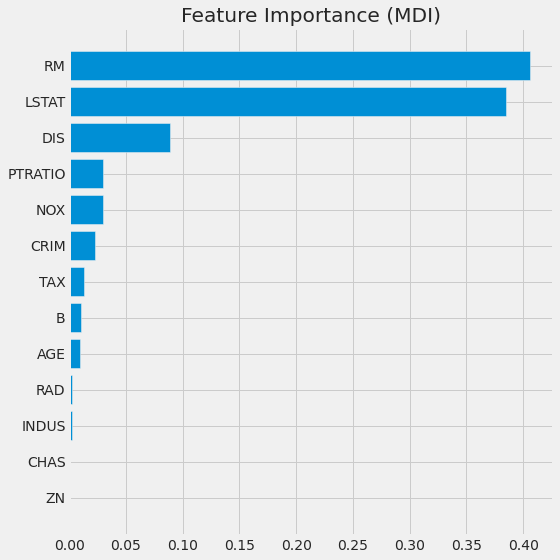

In [421]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
#
# Get Feature importance data using feature_importances_ attribute
#
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(bhp.feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(gbr, X_test_std, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

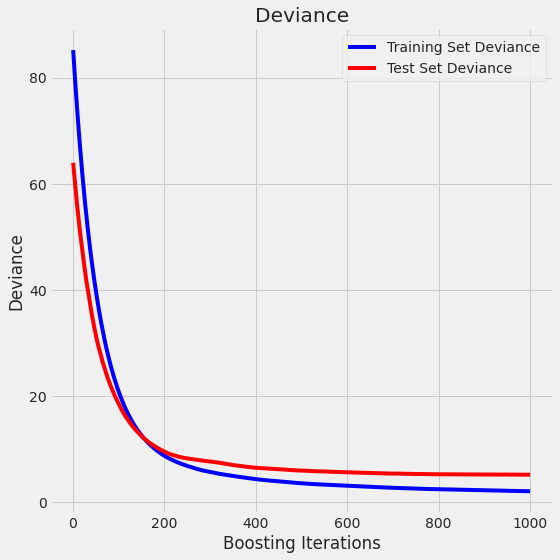

In [422]:
test_score = np.zeros((gbr_params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test_std)):
    test_score[i] = gbr.loss_(y_test, y_pred)
 
fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(gbr_params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(gbr_params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

FP-tree Pseudocode and Explanation

    Step 1: Deduce the ordered frequent items. For items with the same frequency, the order is given by the alphabetical order.
    Step 2: Construct the FP-tree from the above data
    Step 3: From the FP-tree above, construct the FP-conditional tree for each item (or itemset).
    Step 4: Determine the frequent patterns.

In [423]:
from __future__ import division, print_function
import numpy as np
import itertools


class FPTreeNode():
    def __init__(self, item=None, support=1):
        # 'Value' of the item
        self.item = item
        # Number of times the item occurs in a
        # transaction
        self.support = support
        # Child nodes in the FP Growth Tree
        self.children = {}


class FPGrowth():
    """A method for determining frequent itemsets in a transactional database. 
    This is done by building a so called FP Growth tree, which can then be mined
    to collect the frequent itemsets. More effective than Apriori for large transactional
    databases.
    Parameters:
    -----------
    min_sup: float
        The minimum fraction of transactions an itemets needs to
        occur in to be deemed frequent
    """
    def __init__(self, min_sup=0.3):
        self.min_sup = min_sup
        # The root of the initial FP Growth Tree
        self.tree_root = None
        # Prefixes of itemsets in the FP Growth Tree
        self.prefixes = {}
        self.frequent_itemsets = []

    # Count the number of transactions that contains item.
    def _calculate_support(self, item, transactions):
        count = 0
        for transaction in transactions:
            if item in transaction:
                count += 1
        support = count
        return support


    def _get_frequent_items(self, transactions):
        """ Returns a set of frequent items. An item is determined to
        be frequent if there are atleast min_sup transactions that contains
        it. """
        # Get all unique items in the transactions
        unique_items = set(
            item for transaction in transactions for item in transaction)
        items = []
        for item in unique_items:
            sup = self._calculate_support(item, transactions)
            if sup >= self.min_sup:
                items.append([item, sup])
        # Sort by support - Highest to lowest
        items.sort(key=lambda item: item[1], reverse=True)
        frequent_items = [[el[0]] for el in items]
        # Only return the items
        return frequent_items

    def _insert_tree(self, node, children):
        """ Recursive method which adds nodes to the tree. """
        if not children:
            return
        # Create new node as the first item in children list
        child_item = children[0]
        child = FPTreeNode(item=child_item)
        # If parent already contains item => increase the support
        if child_item in node.children:
            node.children[child.item].support += 1
        else:
            node.children[child.item] = child

        # Execute _insert_tree on the rest of the children list
        # from the new node
        self._insert_tree(node.children[child.item], children[1:])

    def _construct_tree(self, transactions, frequent_items=None):
        if not frequent_items:
            # Get frequent items sorted by support
            frequent_items = self._get_frequent_items(transactions)
        unique_frequent_items = list(
            set(item for itemset in frequent_items for item in itemset))
        # Construct the root of the FP Growth tree
        root = FPTreeNode()
        for transaction in transactions:
            # Remove items that are not frequent according to
            # unique_frequent_items
            transaction = [item for item in transaction if item in unique_frequent_items]
            transaction.sort(key=lambda item: frequent_items.index([item]))
            self._insert_tree(root, transaction)

        return root

    def print_tree(self, node=None, indent_times=0):
        """ Recursive method which prints the FP Growth Tree """
        if not node:
            node = self.tree_root
        indent = "    " * indent_times
        print ("%s%s:%s" % (indent, node.item, node.support))
        for child_key in node.children:
            child = node.children[child_key]
            self.print_tree(child, indent_times + 1)


    def _is_prefix(self, itemset, node):
        """ Makes sure that the first item in itemset is a child of node 
        and that every following item in itemset is reachable via that path """
        for item in itemset:
            if not item in node.children:
                return False
            node = node.children[item]
        return True


    def _determine_prefixes(self, itemset, node, prefixes=None):
        """ Recursive method that adds prefixes to the itemset by traversing the 
        FP Growth Tree"""
        if not prefixes:
            prefixes = []

        # If the current node is a prefix to the itemset
        # add the current prefixes value as prefix to the itemset
        if self._is_prefix(itemset, node):
            itemset_key = self._get_itemset_key(itemset)
            if not itemset_key in self.prefixes:
                self.prefixes[itemset_key] = []
            self.prefixes[itemset_key] += [{"prefix": prefixes, "support": node.children[itemset[0]].support}]

        for child_key in node.children:
            child = node.children[child_key]
            # Recursive call with child as new node. Add the child item as potential
            # prefix.
            self._determine_prefixes(itemset, child, prefixes + [child.item])


    def _get_itemset_key(self, itemset):
        """ Determines the look of the hashmap key for self.prefixes
        List of more strings than one gets joined by '-' """
        if len(itemset) > 1:
            itemset_key = "-".join(itemset)
        else:
            itemset_key = str(itemset[0])
        return itemset_key

    def _determine_frequent_itemsets(self, conditional_database, suffix):
        # Calculate new frequent items from the conditional database
        # of suffix
        frequent_items = self._get_frequent_items(conditional_database)

        cond_tree = None

        if suffix:
            cond_tree = self._construct_tree(conditional_database, frequent_items)
            # Output new frequent itemset as the suffix added to the frequent
            # items
            self.frequent_itemsets += [el + suffix for el in frequent_items]

        # Find larger frequent itemset by finding prefixes
        # of the frequent items in the FP Growth Tree for the conditional
        # database.
        self.prefixes = {}
        for itemset in frequent_items:
            # If no suffix (first run)
            if not cond_tree:
                cond_tree = self.tree_root
            # Determine prefixes to itemset
            self._determine_prefixes(itemset, cond_tree)
            conditional_database = []
            itemset_key = self._get_itemset_key(itemset)
            # Build new conditional database
            if itemset_key in self.prefixes:
                for el in self.prefixes[itemset_key]:
                    # If support = 4 => add 4 of the corresponding prefix set
                    for _ in range(el["support"]):
                        conditional_database.append(el["prefix"])
                # Create new suffix
                new_suffix = itemset + suffix if suffix else itemset
                self._determine_frequent_itemsets(conditional_database, suffix=new_suffix)

    def find_frequent_itemsets(self, transactions, suffix=None, show_tree=False):
        self.transactions = transactions

        # Build the FP Growth Tree
        self.tree_root = self._construct_tree(transactions)
        if show_tree:
            print ("FP-Growth Tree:")
            self.print_tree(self.tree_root)

        self._determine_frequent_itemsets(transactions, suffix=None)

        return self.frequent_itemsets

In [424]:
transactions = np.array([
        ["A", "B", "D", "E"],
        ["B", "C", "E"],
        ["A", "B", "D", "E"],
        ["A", "B", "C", "E"],
        ["A", "B", "C", "D", "E"],
        ["B", "C", "D"]
    ])
print ("")
print ("+---------------+")
print ("|   FP-Growth   |")
print ("+---------------+")

min_sup = 3
print ("Minimum Support: %s" % min_sup)
print ("")
print ("Transactions:")
for transaction in transactions:
  print ('''\t%s''' % transaction) 



fp_growth = FPGrowth(min_sup=min_sup)

print ("")
# Get and print the frequent itemsets
frequent_itemsets = fp_growth.find_frequent_itemsets(transactions, show_tree=True)

print ("")
print ("Frequent itemsets:")
for itemset in frequent_itemsets:
 print ("\t%s" % itemset)
print ("")


+---------------+
|   FP-Growth   |
+---------------+
Minimum Support: 3

Transactions:
	['A', 'B', 'D', 'E']
	['B', 'C', 'E']
	['A', 'B', 'D', 'E']
	['A', 'B', 'C', 'E']
	['A', 'B', 'C', 'D', 'E']
	['B', 'C', 'D']

FP-Growth Tree:
None:1
    B:6
        E:5
            A:4
                D:3
                    C:1
                C:1
            C:1
        D:1
            C:1

Frequent itemsets:
	['B', 'E']
	['E', 'A']
	['B', 'A']
	['E', 'B', 'A']
	['B', 'D']
	['E', 'D']
	['A', 'D']
	['B', 'E', 'D']
	['E', 'A', 'D']
	['B', 'A', 'D']
	['E', 'B', 'A', 'D']
	['B', 'C']
	['E', 'C']
	['B', 'E', 'C']



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
